In [2]:
from pathlib import Path
import csv
import os
from pprint import pprint
from pyrca.analyzers.epsilon_diagnosis import EpsilonDiagnosis, EpsilonDiagnosisConfig
import pandas as pd
from pyrca.analyzers.bayesian import BayesianNetwork
from pyrca.graphs.causal.pc import PC
from pyrca.analyzers.rcd import RCD
from pyrca.analyzers.ht import HT
from pyrca.analyzers.random_walk import RandomWalk, RandomWalkConfig
from causallearn.search.ConstraintBased.PC import pc
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io
import networkx as nx
import numpy as np

JVM already started


In [8]:
# SYSTEM = 'sockshop'
SYSTEM = 'trainticket'
# Define the main directory
DATA_FOLDER = Path(f"../../../vuDevOps/data_collection/{SYSTEM}-data/")
# TRAIN_DATA_FOLDER = f'C:\scul\Thesis\Data Analysis\{SYSTEM}-data\normal'
# NORMAL_DATA_PATH = os.path.join(DATA_FOLDER, "normal")
normal_data = pd.read_csv("../../AD/ts-normal_data.csv")
anomalous_data = pd.read_csv("../../AD/ts-anomalous_data.csv")
K = 3
services_to_drop = ["redis", "rabbitmq"]

In [9]:
def print_results(results, model, trial_path, level):   

    # Extracting node names
    nodes_list = [node[0] for node in results['root_cause_nodes']]

    # Writing nodes_list to a CSV file
    csv_filename = f'{trial_path}\{model}_{level}_results.csv'

    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Root Cause'])
        writer.writerows([[node] for node in nodes_list])

In [13]:
def run_rcd(train_df, test_df, trial_path, gamma_level, level_name):
    result_file = os.path.join(trial_path, f'rcd_{level_name}_results.csv')
    if os.path.exists(result_file):
        print(f"RCD ({level_name}) already done → {result_file}")
        return

    model = RCD(config=RCD.config_class(start_alpha=0.05, k = K, bins= 5, gamma=gamma_level, localized=True))
    
    results = model.find_root_causes(train_df, test_df)
    print_results(results.to_dict(), 'rcd', trial_path, level_name)

In [14]:
def run_circa(train_df, test_df, trial_path, alpha_level, level_name):
    result_file = os.path.join(trial_path, f'circa_{level_name}_results.csv')
    if os.path.exists(result_file):
        print(f"CIRCA ({level_name}) already done → {result_file}")
        return

    # Infer causal graph from the training data
    cg = pc(data=train_df.to_numpy(), alpha=alpha_level)
    adj = cg.G.graph

    adj_matrix = pd.DataFrame(adj, index=train_df.columns, columns=train_df.columns)

    model = HT(config=HT.config_class(adj_matrix, aggregator='max', root_cause_top_k=K))
    model.train(train_df)
    
    results = model.find_root_causes(test_df)
    print_results(results.to_dict(), 'circa', trial_path, level_name)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

normal_data.dropna(axis=1, inplace=True)
anomalous_data.dropna(axis=1, inplace=True)

columns_to_drop = [col for col in normal_data.columns if any(substring in col for substring in services_to_drop)]
normal_data = normal_data.drop(columns=columns_to_drop)
anomalous_data = anomalous_data.drop(columns=columns_to_drop)
grouped_anomalous_data = anomalous_data.groupby(['scenario', 'service', 'users', 'repetition'])

rcd_levels = {
    "high": 6,
    "low": 4
}

circa_levels = {
    "high": 0.1,
    "low": 0.01
}

for (scenario, service, users, repetition), group_df in grouped_anomalous_data:

    for level in ["high", "low"]:
        gamma = rcd_levels[level]
        alpha = circa_levels[level]

        # Filter the training data from the normal_data DataFrame based on the scenario and users
        train_df = normal_data[
            (normal_data['scenario'] == scenario) & 
            (normal_data['users'] == users) & 
            (normal_data['repetition'] == repetition)
        ].copy()

        # Filter the test data from the anomalous_data DataFrame for the current scenario, service, users, and repetition
        test_df = anomalous_data[
                (anomalous_data['scenario'] == scenario) & 
                (anomalous_data['service'] == service) & 
                (anomalous_data['users'] == users) & 
                (anomalous_data['repetition'] == repetition)
        ].copy()

        trial_path = f"../results/{SYSTEM}/{scenario}/{service}/{users}/{repetition}"
        os.makedirs(trial_path, exist_ok=True)

        train_df = train_df.loc[:, ~(train_df == 0).all()]

        # Filter columns that end with _energy, _cpu, _memory_rss
        columns_to_keep = train_df.filter(regex='(_energy|_cpu|_memory_rss)$').columns

        train_df = train_df[columns_to_keep]
        test_df = test_df[columns_to_keep]

        print(trial_path)
        
        run_rcd(train_df, test_df, trial_path, gamma_level=gamma, level_name=level)
        run_circa(train_df, test_df, trial_path, alpha_level=alpha, level_name=level)

  0%|          | 0/13 [00:00<?, ?it/s]

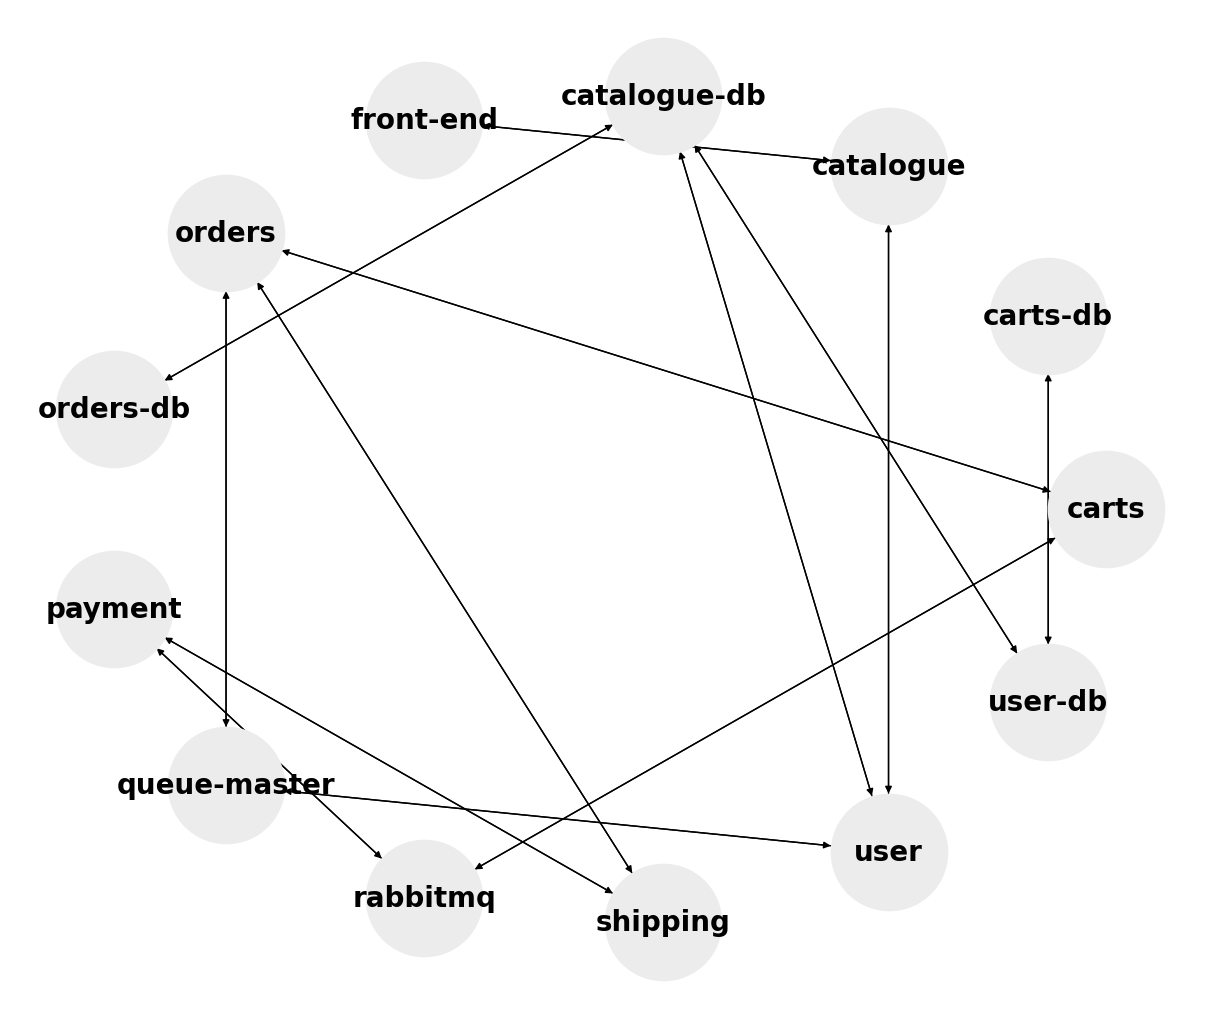

In [19]:
normal_data = pd.read_csv("../../AD/normal_data.csv")
anomalous_data = pd.read_csv("../../AD/anomalous_data.csv")

train_df = normal_data[
    (normal_data['scenario'] == 'scenario_A') & 
    (normal_data['users'] == 100) & 
    (normal_data['repetition'] == 'repetition_1')
].copy()

test_df = anomalous_data[
        (anomalous_data['scenario'] == 'scenario_A') & 
        (anomalous_data['service'] == 'front-end') & 
        (anomalous_data['users'] == 100) & 
        (anomalous_data['repetition'] == 'repetition_1')
].copy()

train_df = train_df.loc[:, ~(train_df == 0).all()]
columns_to_keep = train_df.filter(regex='(_energy)$').columns

train_df = train_df[columns_to_keep]
test_df = test_df[columns_to_keep]

labels = [f'{col}' for i, col in enumerate(train_df.columns)]
cg = pc(data=train_df.to_numpy(), alpha=0.05)
adj = cg.G.graph

adj_matrix = pd.DataFrame(adj, index=train_df.columns, columns=train_df.columns)

# Convert adjacency matrix to a NetworkX graph
nx_graph = nx.from_pandas_adjacency(adj_matrix)

# Remove the "_energy" suffix from the graph nodes
nx_graph = nx.relabel_nodes(nx_graph, lambda x: x.split('_')[0])

nx_graph = nx.DiGraph(nx_graph)
plt.figure(figsize=(12, 10))
pos = nx.circular_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_color="#ECECEC", node_size=7000, font_size=20, font_weight='bold')
plt.show()